In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import sklearn.metrics as metrics
import seaborn as sns; sns.set()
from itertools import combinations

model = LinearRegression(fit_intercept = True)

raw1ds = pd.read_excel('experiment8a.xlsx')   #reads from preprocessed datasets

X = raw1ds.drop(['measured_wearout'], axis = 1)            #declaration of input and output dataframes
Y = raw1ds['measured_wearout']                             # X and Y will form the basis from which feature selection...
                                                          # ...will act upon
    
ZERO = []                           # a horizontal line cutting though (0,0)
for i in range(len(raw1ds)):      # to be used in plotting to show the boundary between +ve and -ve error
    ZERO.append(0)   

In [2]:
# We would like to test if the random states used for the train/test splitting affects the goodness of fit of the resulting...
# ... MLR model. For this, we test 100 random states and calculate the R2 metrics of the corresponding MLR model

tempX = X.copy()   # Makes a copy of input parameter DF

rslist = []
R2list = []

for i in range(10):           # All training and testing data are temporary so as to not interfere with future MLR models
    
    tempX_train, tempX_test, tempY_train, tempY_test = train_test_split(tempX, Y, test_size = 0.2, random_state = i )

    model.fit(tempX_train, tempY_train)

    tempY_pred = model.predict(tempX_test)

    tempR2 = metrics.r2_score(tempY_test, tempY_pred)
    
    rslist.append(i)
    R2list.append(tempR2)

In [3]:
RSCDF = pd.DataFrame({'R2': R2list}, index = rslist) # Creates a DF of R2 values with corresponding random state integer... 
                                                     # ... as index
RSCDF = RSCDF.sort_values( by = ['R2'], ascending = False)     # sort RSCDF in increasing R2 values

R2range = RSCDF.max() - RSCDF.min()

MaxPercentageRange = R2range/(RSCDF.min())       # we divide the range by the smallest value of R2 to get the largest...
                                                # ... value of [range as a percentage of possible R2 values]
    
MaxPercentageRange[0]*100      # Because of how Pandas is written, MaxPercentageRange is a single cell Series
                               # We append [0] to draw out the float value (Optional)



# The range is at most 0.0554% of the possible R2 values. This means that the goodness of fit of MLR models does not...
# ... change meaningfully with respect to the random state used

0.055405397368728876

In [4]:
RSC = RSCDF.index[0]    # We pick the random state that gave the highest R2 value, and use it for all remaining data splitting
RSC
##################       END OF RANDOM STATE CHOOSING      ##################3

9

<AxesSubplot:>

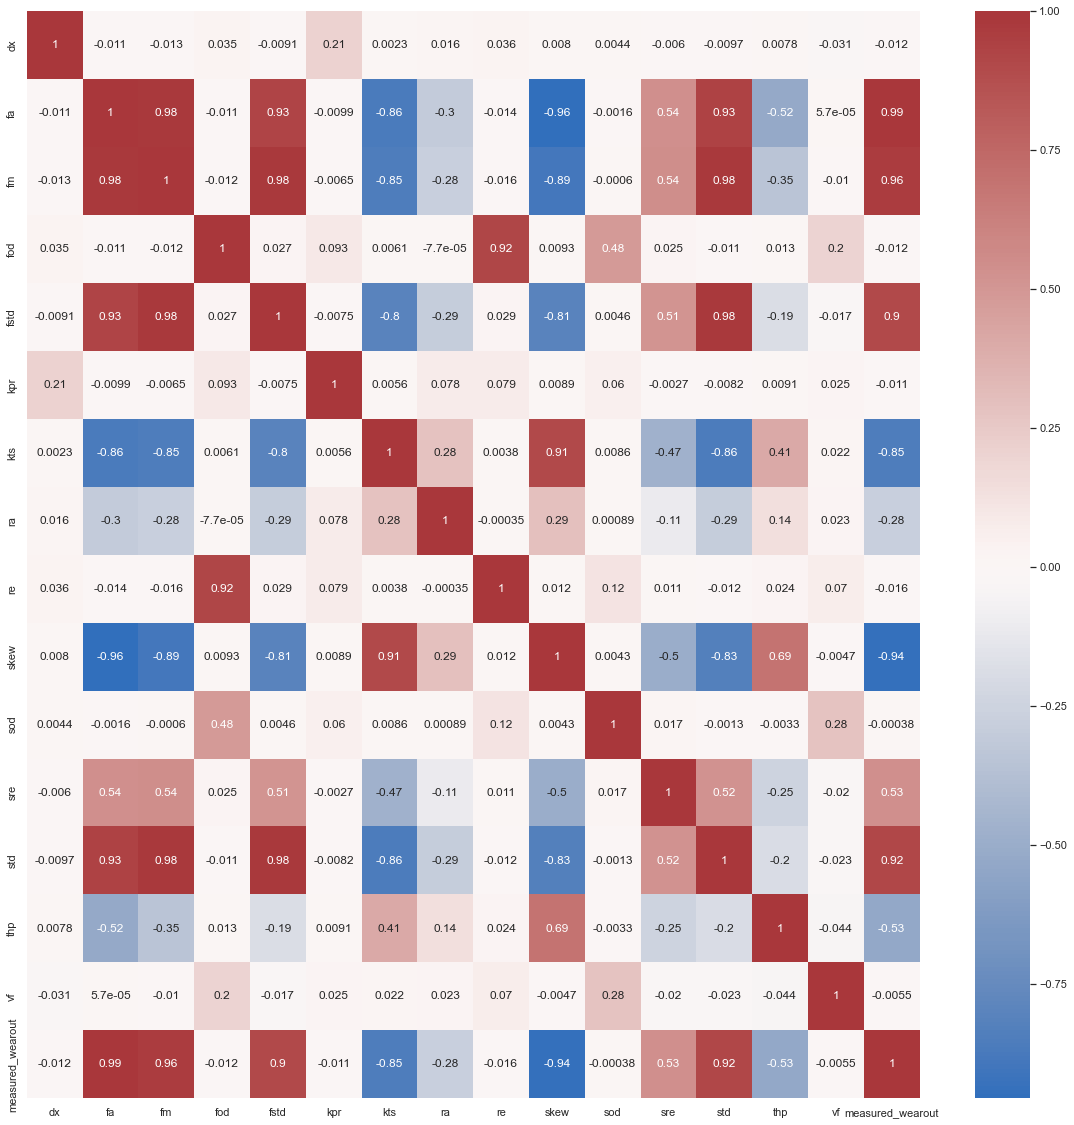

In [5]:
corr = raw1ds.corr(method='pearson')      #create correlation plot with 100% of preprocessed 1st cutter datasets
sns.set(rc={'figure.figsize':(20,20)})
sns.heatmap(corr, annot=True, cmap="vlag", center=0)

In [6]:
#feature selection

corrRow = corr.iloc[-1]                      #last row of corr table
corrRow = corrRow.drop('measured_wearout')   #contains input parameter correlation values wrt output parameter
corrRowSorted = corrRow.sort_values(ascending = False, key = abs)     #sorted corrRow from high to low r magnitude

corrRowSorted



# we will be using this corrRowSorted later on

fa      0.985036
fm      0.962200
skew   -0.943047
std     0.915847
fstd    0.900706
kts    -0.854838
sre     0.534269
thp    -0.532589
ra     -0.283093
re     -0.015664
dx     -0.011790
fod    -0.011504
kpr    -0.010948
vf     -0.005492
sod    -0.000377
Name: measured_wearout, dtype: float64

In [20]:
rthreshold = 0.98  #user defined correlation/ pearson's r limit

reducedIndex = corrRowSorted.index[ abs(corrRowSorted) > rthreshold] # stores the index of parameters ...
                                                         # ...of which r value magnitude is greater than threshold

reducedIndex   # print out the list of parameters that are above the threshold

# Note that if a full parameter model is desired,
# threshold should be set to 0 (ie even non-correlated parameters are accepted)
# This is to reduce the code clutter

reducedIndexString = ''      #to be used in print() in the next cell, for user friendliness only

for index in reducedIndex:
    reducedIndexString = reducedIndexString + ' ' + index
    
reducedIndexString

' fa'

In [21]:
rX = X[reducedIndex]            #reduced dataset, in accordance to user defined r limit

# Creating training and testing data from user defined threshold.
rX_train, rX_test, Y_train, Y_test = train_test_split(rX, Y, test_size = 0.2, random_state = RSC)

In [22]:
rMLRtitle = 'Reduced MLR model using parameters of |r| above ' + str(rthreshold)

if (len(reducedIndex) == 15):
    rMLRtitle = 'MLR model using all parameters'

Pearson's r Threshold used: 0.98
Parameters used: fa

R2: 0.9706
MAE: 0.0108
MSE: 0.0002
RMSE: 0.0129


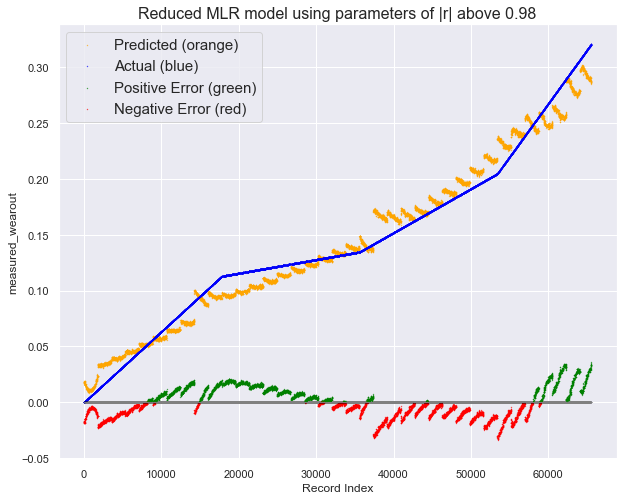

In [35]:
plt.figure(figsize=(10, 8))
plt.title(rMLRtitle, size=16)

print('Pearson\'s r Threshold used: ' + str(rthreshold))
print('Parameters used:' + reducedIndexString + '\n')

model.fit(rX_train, Y_train)

rY_pred = model.predict(rX_test)    #using reduced parameters

rY_error = Y_test-rY_pred
rY_errorP = rY_error[rY_error >= 0]            #splitting prediction error into 
rY_errorN = rY_error[rY_error < 0]              #positive(green) and negative(red) regions for better viewing

mse = mean_squared_error(Y_test, rY_pred)       #goodness-of-fit metrics
rmse = np.sqrt(mse)     
R2 = r2_score(Y_test, rY_pred)
mae = mean_absolute_error(Y_test, rY_pred)

print('R2: ' + str(R2.round(4)))
print('MAE: ' + str(mae.round(4)))
print('MSE: ' + str(mse.round(4)))
print('RMSE: ' + str(rmse.round(4)))

plt.scatter(Y_test.index, rY_pred, color='orange',label='Predicted (orange)',s=0.1)
plt.scatter(Y_test.index, Y_test, color='blue',label='Actual (blue)', s=0.1)
plt.scatter(rY_errorP.index, rY_errorP, color='green',label= 'Positive Error (green)',s=0.1)
plt.scatter(rY_errorN.index, rY_errorN, color='red',label='Negative Error (red)',s=0.1)

plt.scatter(range(len(ZERO)),ZERO, color = 'grey', s = 0.001)

plt.ylabel('measured_wearout')
plt.xlabel('Record Index')

plt.legend(fontsize = 15)

In [24]:
Y_train

45307    0.172678
36517    0.138110
8115     0.051432
61429    0.281191
17398    0.110259
           ...   
65462    0.319708
501      0.003181
55934    0.228711
20828    0.116493
57726    0.245825
Name: measured_wearout, Length: 52428, dtype: float64

In [25]:
# PCA TIME
pca = PCA()

PCcolnames = []                # making an array to store PC column names

for i in range(15):
    to_add = 'PC' + str(i+1)
    PCcolnames.append(to_add)
    
PCcolnames = pd.Series(PCcolnames)

In [26]:
# creating full-parameter training + testing data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = RSC)
# Y_test is still identical to the previous Y_test, because the seed variables are the same

# converting training data into PC space
X_trainPC = pca.fit_transform(X_train)    # gives index-less np.array
X_trainPC = pd.DataFrame(X_trainPC, index = X_train.index, columns = PCcolnames)  #converting to DF

# converting testing data into PC space
X_testPC = pca.transform(X_test)  # gives index-less np.array
X_testPC = pd.DataFrame(X_testPC, index = X_test.index, columns = PCcolnames)    #converting to DF

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15
percent variance,40.87,14.59,8.15,7.59,6.85,6.17,5.14,4.81,4.26,1.43,0.07,0.06,0.01,0.01,0.01
cumulative percentage,40.87,55.45,63.61,71.19,78.04,84.21,89.35,94.16,98.42,99.85,99.92,99.97,99.99,99.99,100.00


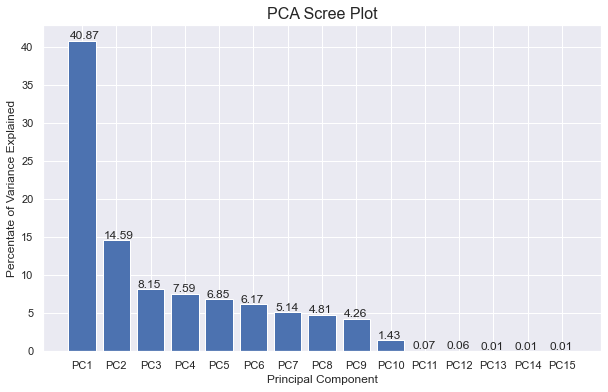

In [28]:
# creating Scree plot. This is based on 80% of 1st cutter data

percent_variance = (pca.explained_variance_ratio_* 100).round(2)
percent_variance = pd.Series(percent_variance)

cumsum = (np.cumsum(pca.explained_variance_ratio_)*100).round(2)
cumsum = pd.Series(cumsum)

ScreeDF = pd.DataFrame()   #building dataframe to hold % variance and cumulative %
ScreeDF = ScreeDF.append(percent_variance, ignore_index = True)
ScreeDF = ScreeDF.append(cumsum, ignore_index = True)
ScreeDF.index = ['percent variance','cumulative percentage']
ScreeDF.columns = PCcolnames


plt.figure(figsize=(10, 6))
bars = plt.bar(x= range(1,16), height=percent_variance, tick_label= PCcolnames)
plt.ylabel('Percentate of Variance Explained')
plt.xlabel('Principal Component')
plt.title('PCA Scree Plot', size=16)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() +0.03, yval + .2, yval )
    
ScreeDF

In [29]:
# user inputs PC variance threshold to set the percentage of variance the model has to account for, and drops the 
# remaining PC 

varthreshold = 0.0

quantity = len(cumsum[cumsum < varthreshold * 100]) + 1       #returns number of PCs needed to just exceed the threshold

reducedPCIndex = PCcolnames[:quantity]                        # PC selection based on threshold, to be used to ...
                                                              # limit training/testing data

reducedPCIndexString = ''                          # to be used in print() for readability
cumsumString = str(cumsum[quantity - 1])

for PC in reducedPCIndex:
    reducedPCIndexString = reducedPCIndexString + ' ' + PC

reducedPCIndexString

' PC1'

In [30]:
# Applying variance threshold to PC selection

rX_trainPC = X_trainPC[reducedPCIndex]
rX_testPC = X_testPC[reducedPCIndex]

In [31]:
rMLRtitlePC = 'Reduced MLR model using Principal Components of explained variance above ' + str(varthreshold*100) + '%'

if (len(reducedPCIndex) == 15):
    rMLRtitlePC = 'MLR model using all Principal Components'

Variance Explained Threshold Used: 0.0%
Principle Components Used: PC1

Actual Variance Explained by PC Used: 40.87%
R2: 0.9446
MAE: 0.0145
MSE: 0.0003
RMSE: 0.0177


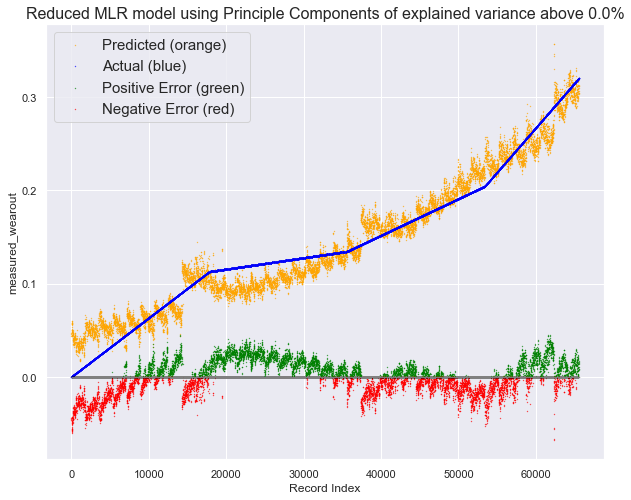

In [32]:
plt.figure(figsize=(10, 8))
plt.title(rMLRtitlePC, size=16)

print('Variance Explained Threshold Used: ' + str(varthreshold*100) + '%')
print('Principal Components Used:' + reducedPCIndexString + '\n')
print('Actual Variance Explained by PC Used: ' + cumsumString + '%')

model.fit(rX_trainPC, Y_train)

rY_predPC = model.predict(rX_testPC)    #using reduced parameters

rY_errorPC = Y_test-rY_predPC
rY_errorPPC = rY_errorPC[rY_errorPC >= 0]            #splitting prediction error into 
rY_errorNPC = rY_errorPC[rY_errorPC < 0]              #positive(green) and negative(red) regions for better viewing

msePC = mean_squared_error(Y_test, rY_predPC)       #goodness-of-fit metrics
rmsePC = np.sqrt(msePC)     
R2PC = r2_score(Y_test, rY_predPC)
maePC = mean_absolute_error(Y_test, rY_predPC)

print('R2: ' + str(R2PC.round(4)))
print('MAE: ' + str(maePC.round(4)))
print('MSE: ' + str(msePC.round(4)))
print('RMSE: ' + str(rmsePC.round(4)))

plt.scatter(Y_test.index, rY_predPC, color='orange',label='Predicted (orange)',s=0.1)
plt.scatter(Y_test.index, Y_test, color='blue',label='Actual (blue)', s=0.1)
plt.scatter(rY_errorPPC.index, rY_errorPPC, color='green',label= 'Positive Error (green)',s=0.1)
plt.scatter(rY_errorNPC.index, rY_errorNPC, color='red',label='Negative Error (red)',s=0.1)

plt.scatter(range(len(ZERO)),ZERO, color = 'grey', s = 0.001)

plt.ylabel('measured_wearout')
plt.xlabel('Record Index')

plt.legend(fontsize = 15)

<AxesSubplot:>

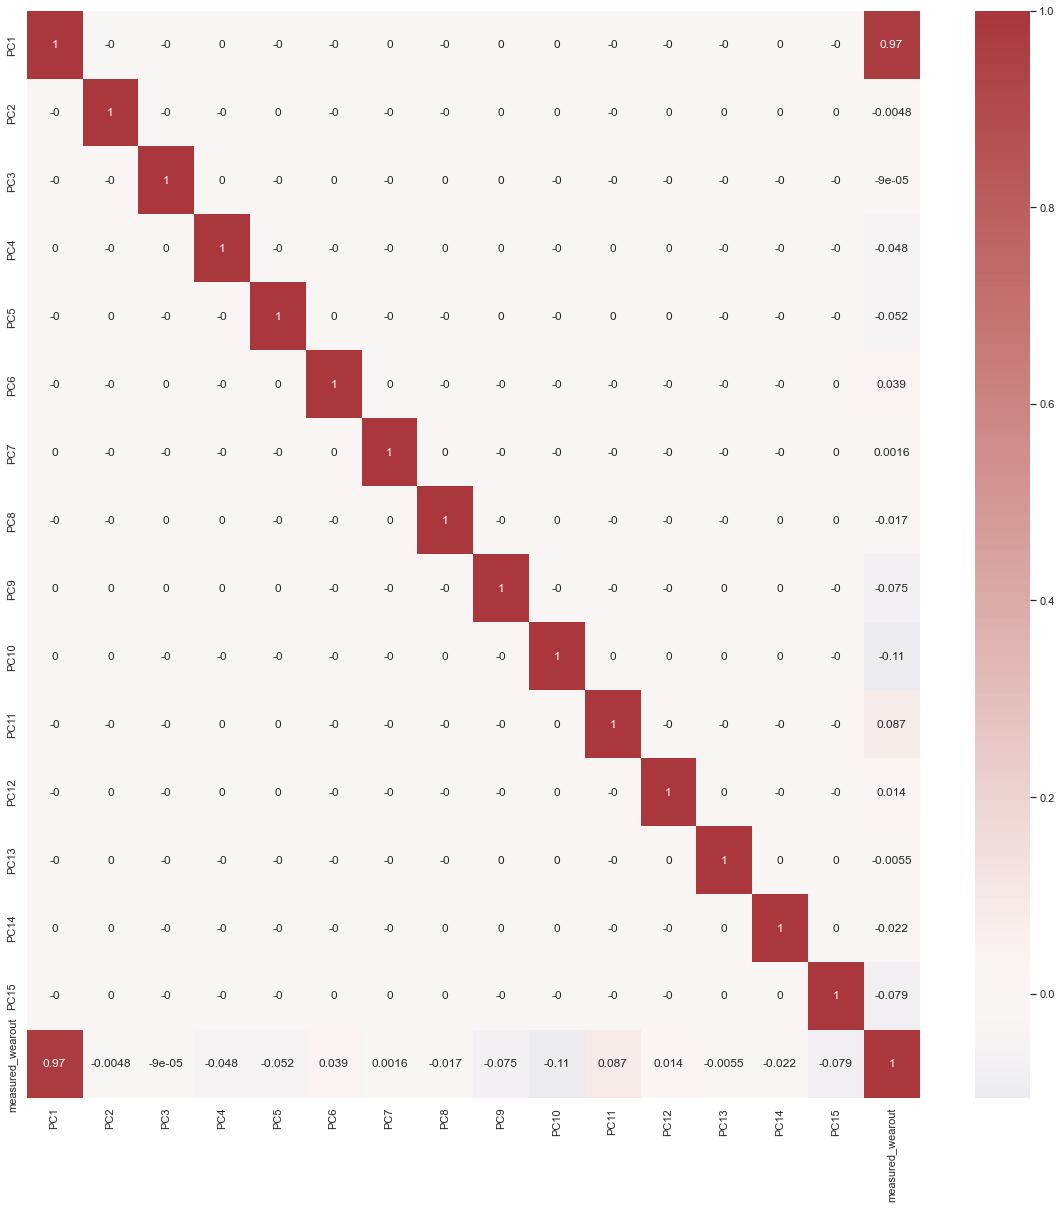

In [36]:
#correlation between PC and measured_wearout in the training dataset

combinedPCdata = X_trainPC.copy()

combinedPCdata['measured_wearout'] = Y_train

PCcorr = combinedPCdata.corr(method='pearson').round(5)      #create correlation plot with 100% of preprocessed 1st cutter datasets
sns.set(rc={'figure.figsize':(20,20)})
sns.heatmap(PCcorr, annot=True, cmap="vlag", center=0)

R2: 0.0083
MAE: 0.0583
MSE: 0.0056
RMSE: 0.0749


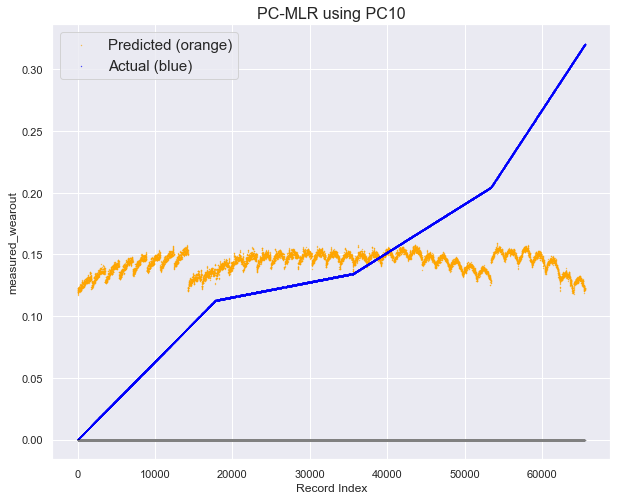

In [38]:
# Just for further visualisation

testPC = 'PC10'                  # select PC from here

testTitle = 'PC-MLR using ' + testPC

plt.figure(figsize=(10, 8))
plt.title(testTitle, size=16)

model.fit(pd.DataFrame(X_trainPC[testPC]), Y_train)

rY_predPC = model.predict(pd.DataFrame(X_testPC[testPC]))    

rY_errorPC = Y_test-rY_predPC
rY_errorPPC = rY_errorPC[rY_errorPC >= 0]            
rY_errorNPC = rY_errorPC[rY_errorPC < 0]              

msePC = mean_squared_error(Y_test, rY_predPC)       
rmsePC = np.sqrt(msePC)     
R2PC = r2_score(Y_test, rY_predPC)
maePC = mean_absolute_error(Y_test, rY_predPC)

print('R2: ' + str(R2PC.round(4)))
print('MAE: ' + str(maePC.round(4)))
print('MSE: ' + str(msePC.round(4)))
print('RMSE: ' + str(rmsePC.round(4)))

plt.scatter(Y_test.index, rY_predPC, color='orange',label='Predicted (orange)',s=0.1)
plt.scatter(Y_test.index, Y_test, color='blue',label='Actual (blue)', s=0.1)

plt.scatter(range(len(ZERO)),ZERO, color = 'grey', s = 0.001)

plt.ylabel('measured_wearout')
plt.xlabel('Record Index')

plt.legend(fontsize = 15)

In [19]:
#END